In [11]:

%load_ext autoreload
%autoreload 2
import bnl
from bnl import viz

## Let's plot!

- Figure 1: how framesize affect the triplet metrics
- Figure 2: how continuous compares with 0.5: scatter plot


799-0
799-1


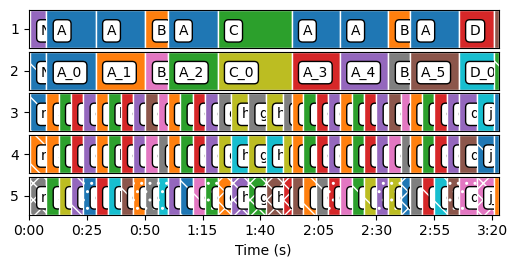

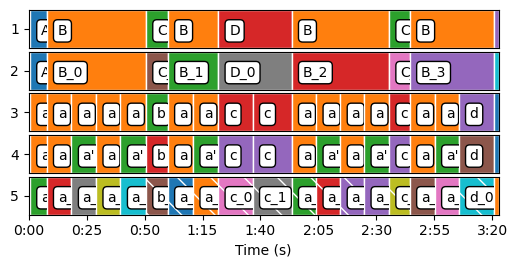

In [50]:
import random
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
while len(salami_hiers) < 2:
    tid = random.choice(tids)
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)

hiers = {'-'.join([str(tid), str(i)]): h for i, h in enumerate(salami_hiers)}

for tid, h in hiers.items():
    print(tid)
    h.expand(format='slm', always_include=False).plot();

## Comparing Mir_eval implementation and my implementation


### Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [2]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import metrics
import os
from pqdm.processes import pqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Create output directory if it doesn't exist
os.makedirs("./compare_implementation", exist_ok=True)

# Determine number of CPU cores to use
n_jobs = max(1, os.cpu_count() - 1)  # Leave one CPU free

# Process tracks in parallel
tids = bnl.fio.salami_tids()
pqdm(tids, metrics.time_salami_track, n_jobs=n_jobs);

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [19]:
## Time to collect
from glob import glob
from tqdm import tqdm
import os
import xarray as xr


In [23]:
results_fpaths = glob('./compare_implementation/*.nc')

das = []
for fp in tqdm(results_fpaths):
    tid = os.path.basename(fp).split('.')[0]
    # Load the data array and assign the tid as a coordinate
    da = xr.open_dataarray(fp)
    da = da.assign_coords(tid=tid)
    da = da.expand_dims('tid')
    das.append(da)

# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')


100%|██████████| 882/882 [00:07<00:00, 123.56it/s]


In [ ]:
#  Save the final data array to a NetCDF file
final_da.to_netcdf('./compare_implementation.nc')


### Alright, I can load from saved data now. Now let's do scatter plot to see how they differ

In [12]:
import importlib
importlib.reload(bnl.viz)

<module 'bnl.viz' from '/Users/xi/code/bnl/bnl/viz.py'>

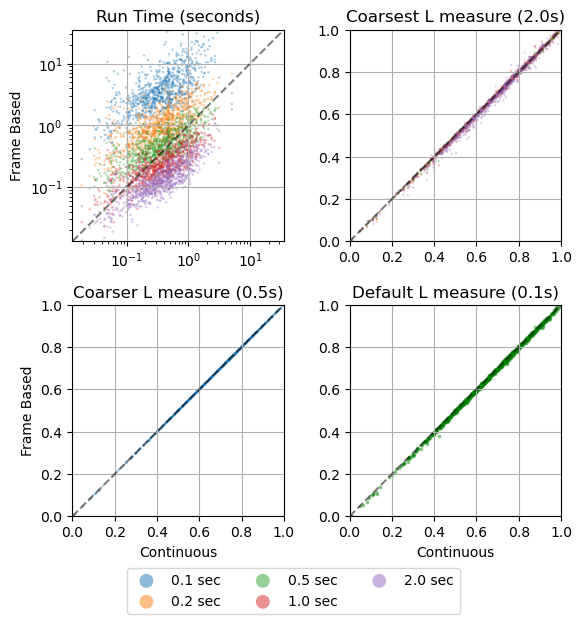

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from bnl import viz
import bnl

# Load the data array from the NetCDF file
results = xr.open_dataarray('./compare_implementation.nc')
fig, axes = plt.subplots(2, 2, figsize=(6,5.8))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()

viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='run_time'), ax=axes[0])
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='lm'), ax=axes[1])
axes[1].set_title('Coarsest L measure (2.0s)')

viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='lm'), frame_sizes=[0.1], ax=axes[2])
axes[2].set_title('Coarser L measure (0.5s)')

handles_green = viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='lm'), frame_sizes=[0.5], ax=axes[3])
axes[3].set_title('Default L measure (0.1s)')
for hg in handles_green.get_legend_handles_labels()[0]:
    hg.set_color('green')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel('Frame Based')
axes[2].set_ylabel('Frame Based')
axes[2].set_xlabel('Continuous')
axes[3].set_xlabel('Continuous')
handles, labels = axes[1].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.5)  # Set transparency for better visibility
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.08))

for ax in axes:
    h, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set it back!
        h.set_sizes([2.5])  # Adjust the size as needed
        h.set_alpha(0.3)  # Set transparency for better visibility
    
# Show the plot
plt.tight_layout()
plt.savefig('./compare_implementation.pdf', transparent=True, bbox_inches='tight')

## Hierarchy Expansion!

(<Figure size 500x250 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>],
       dtype=object))

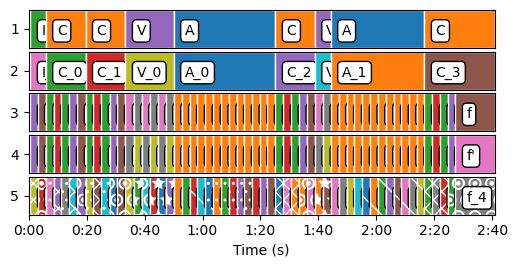

In [88]:
h = bnl.levels2H(h.levels)
h.expand().plot()

## Let's investigate!

- Transitivity, and effects of depth.
- Window and its effects. (It's faster now so we probably don't need it. Let's check the original claim that over all frames are redundant)
    - We can visualize this by looking at how window size affect the per time measures iota alpha and rho.
- Monotonicity Meet and its effect.
    - Again look at per time measures and how they change before and after.



In [4]:
tids = bnl.fio.salami_tids()
hiers = bnl.fio.salami_ref_hiers(tid=tids[0])
hiers

[<bnl.core.H at 0x12a6e7c40>, <bnl.core.H at 0x12a58b520>]

(<Figure size 500x130 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

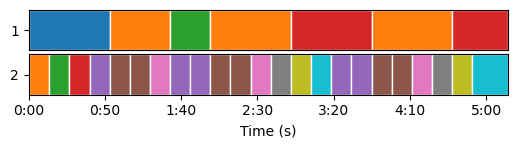

In [8]:
hiers[0].plot(text=False)